In [1]:
import h2o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## 1. Preparation
### 1.1. Loading dataset

In [2]:
df = sns.load_dataset("titanic")
display(df.head())
display(df.describe())
print("Number of missing data")
pd.DataFrame(df.isnull().sum()).T

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Number of missing data


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,0,0,177,0,0,0,2,0,0,0,688,2,0,0


### 1.2. Preprocessing

In [3]:
df.fillna(value={"age": int(df["age"].mode())}, inplace=True)
df['survived'] = df['survived'].replace({0: 'dead', 1:'alived'})
df['pclass'] = df['pclass'].replace({1: '1st-class', 2:'2nd-class', 3: '3rd-class'})
df.head()

/tmp/ipykernel_33/591533569.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  df.fillna(value={"age": int(df["age"].mode())}, inplace=True)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,dead,3rd-class,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,alived,1st-class,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,alived,3rd-class,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,alived,1st-class,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,dead,3rd-class,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 1.3. Feature selection
- We can see that the columns `pclass` and `class` will have the same meaning so we will check if they have the same distribution. Likewise for `embark_town` and `embarked`; 
- Also, the column `alive` and `survived` must be kept one

In [4]:
import warnings
warnings.filterwarnings("ignore")
for idx, col in [('pclass', 'class'), ('embark_town', 'embarked'), ('alive', 'survived'), ('who', 'adult_male')]:
    print(f"{100*'='}\nComparison between {idx} vs {col}")
    display(pd.pivot_table(df, index=idx, columns=col, values='alone', aggfunc='count', fill_value=0))

Comparison between pclass vs class


class,First,Second,Third
pclass,,,
1st-class,216,0,0
2nd-class,0,184,0
3rd-class,0,0,491


Comparison between embark_town vs embarked


embarked,C,Q,S
embark_town,,,
Cherbourg,168,0,0
Queenstown,0,77,0
Southampton,0,0,644


Comparison between alive vs survived


survived,alived,dead
alive,,
no,0,549
yes,342,0


Comparison between who vs adult_male


adult_male,False,True
who,,
child,83,0
man,0,537
woman,271,0


### 1.4. Train-test-split

In [5]:
df = df.dropna(axis=0, subset='embark_town')
X = df.drop(columns=["survived", "alive", "pclass", "who", "sibsp", "adult_male", "deck", "embarked"])
X['alone'] = X['alone'].astype(str)
X['age'] = X['age'].astype(int)
y = df[['sex','embark_town','survived']]
X_train, X_valid, y_train, y_valid = train_test_split(X.drop(columns=['sex','embark_town']), y, test_size=0.3, 
                                                      stratify=y, 
                                                      random_state=42)
df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_valid = pd.concat([X_valid, y_valid], axis=1).reset_index(drop=True)
df_train.head()

,age,parch,fare,class,alone,sex,embark_town,survived
0,20,0,7.8542,Third,True,male,Southampton,dead
1,24,1,25.4667,Third,False,female,Southampton,dead
2,21,0,7.8542,Third,True,male,Southampton,dead
3,24,0,7.3125,Third,True,male,Southampton,dead
4,36,0,13.0000,Second,True,female,Southampton,alived


### 1.5. EDA
#### 1.5.1. For categorial variables

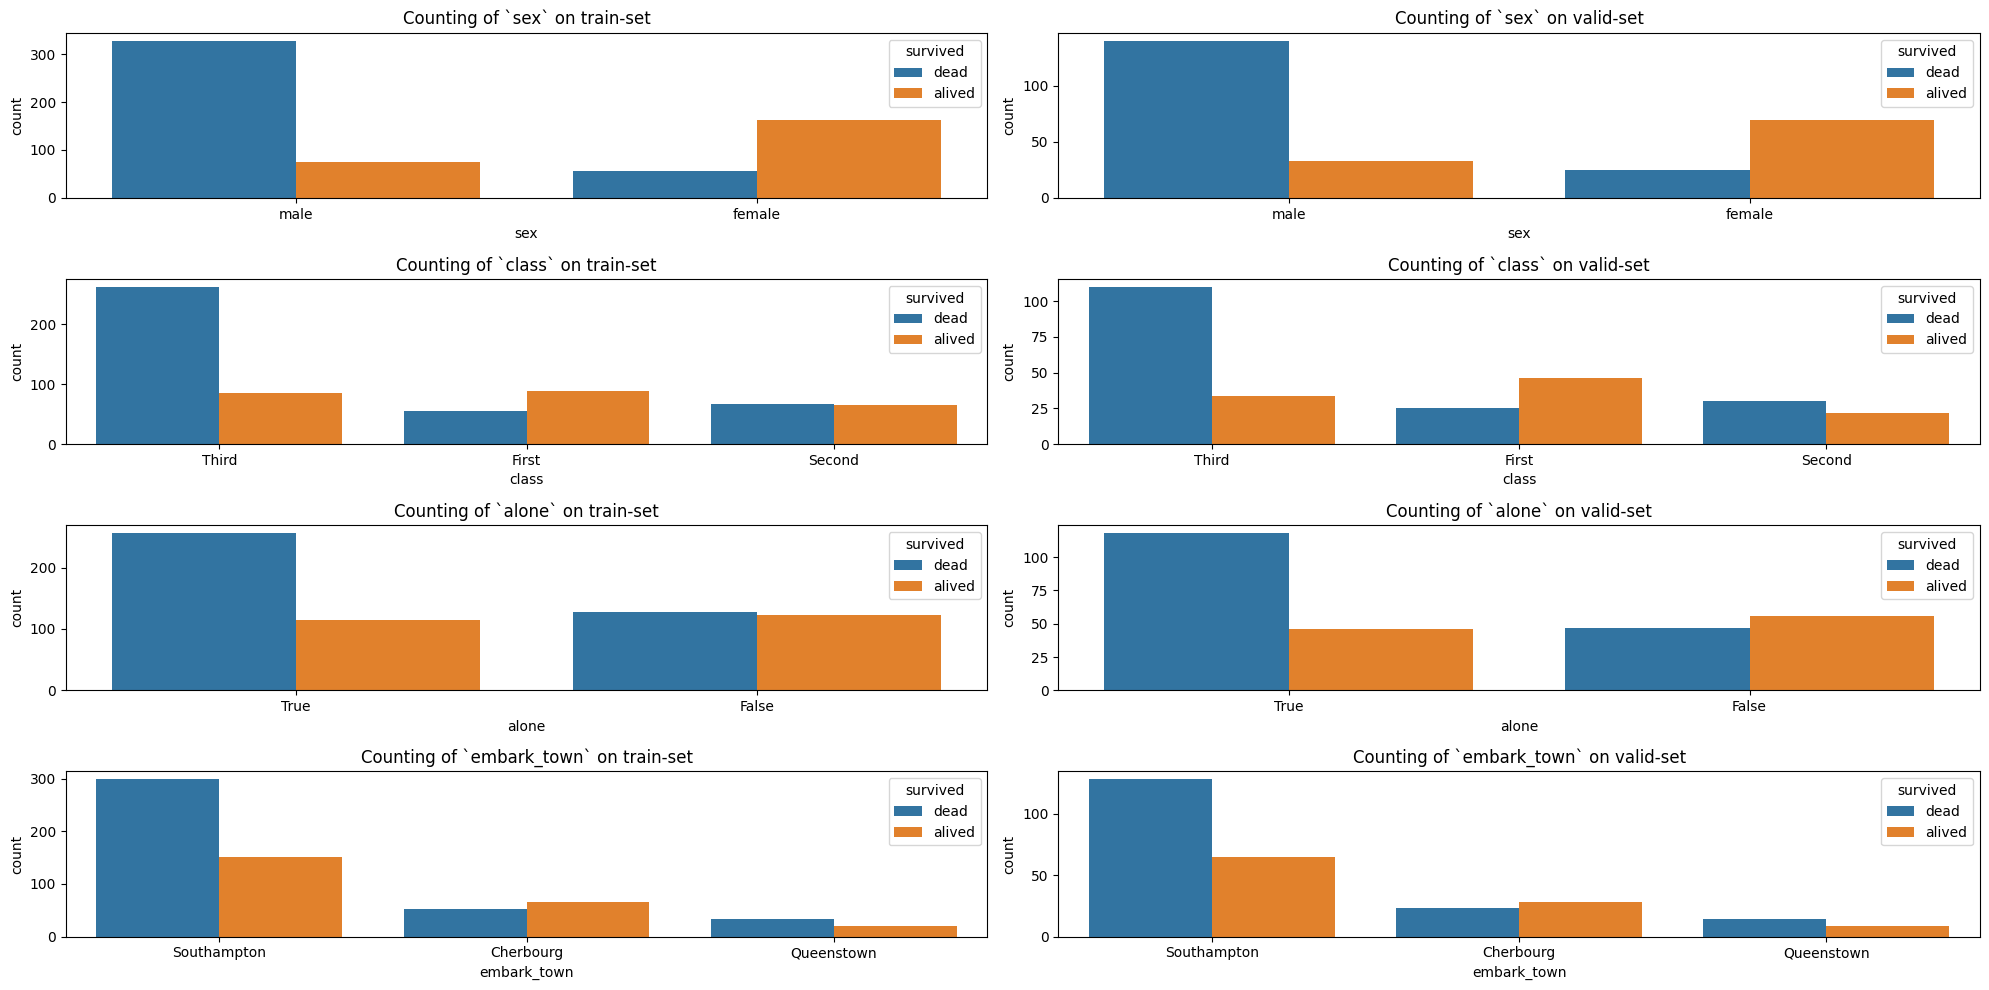

In [6]:
categorial_vrs = ['sex','class','alone', 'embark_town']
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.ravel()
for idx, col in enumerate(categorial_vrs):
    # Plot
    cate_order = X[col].value_counts().index
    sns.countplot(df_train, x=col, hue='survived', order = cate_order, hue_order = ['dead', 'alived'], ax=axes[2*idx])
    sns.countplot(df_valid, x=col, hue='survived', order = cate_order, hue_order = ['dead', 'alived'], ax=axes[2*idx+1])
    # Add title
    axes[2*idx].set_title(f"Counting of `{col}` on train-set")
    axes[2*idx+1].set_title(f"Counting of `{col}` on valid-set")
    
plt.tight_layout()

#### 1.5.2. For numerical variables

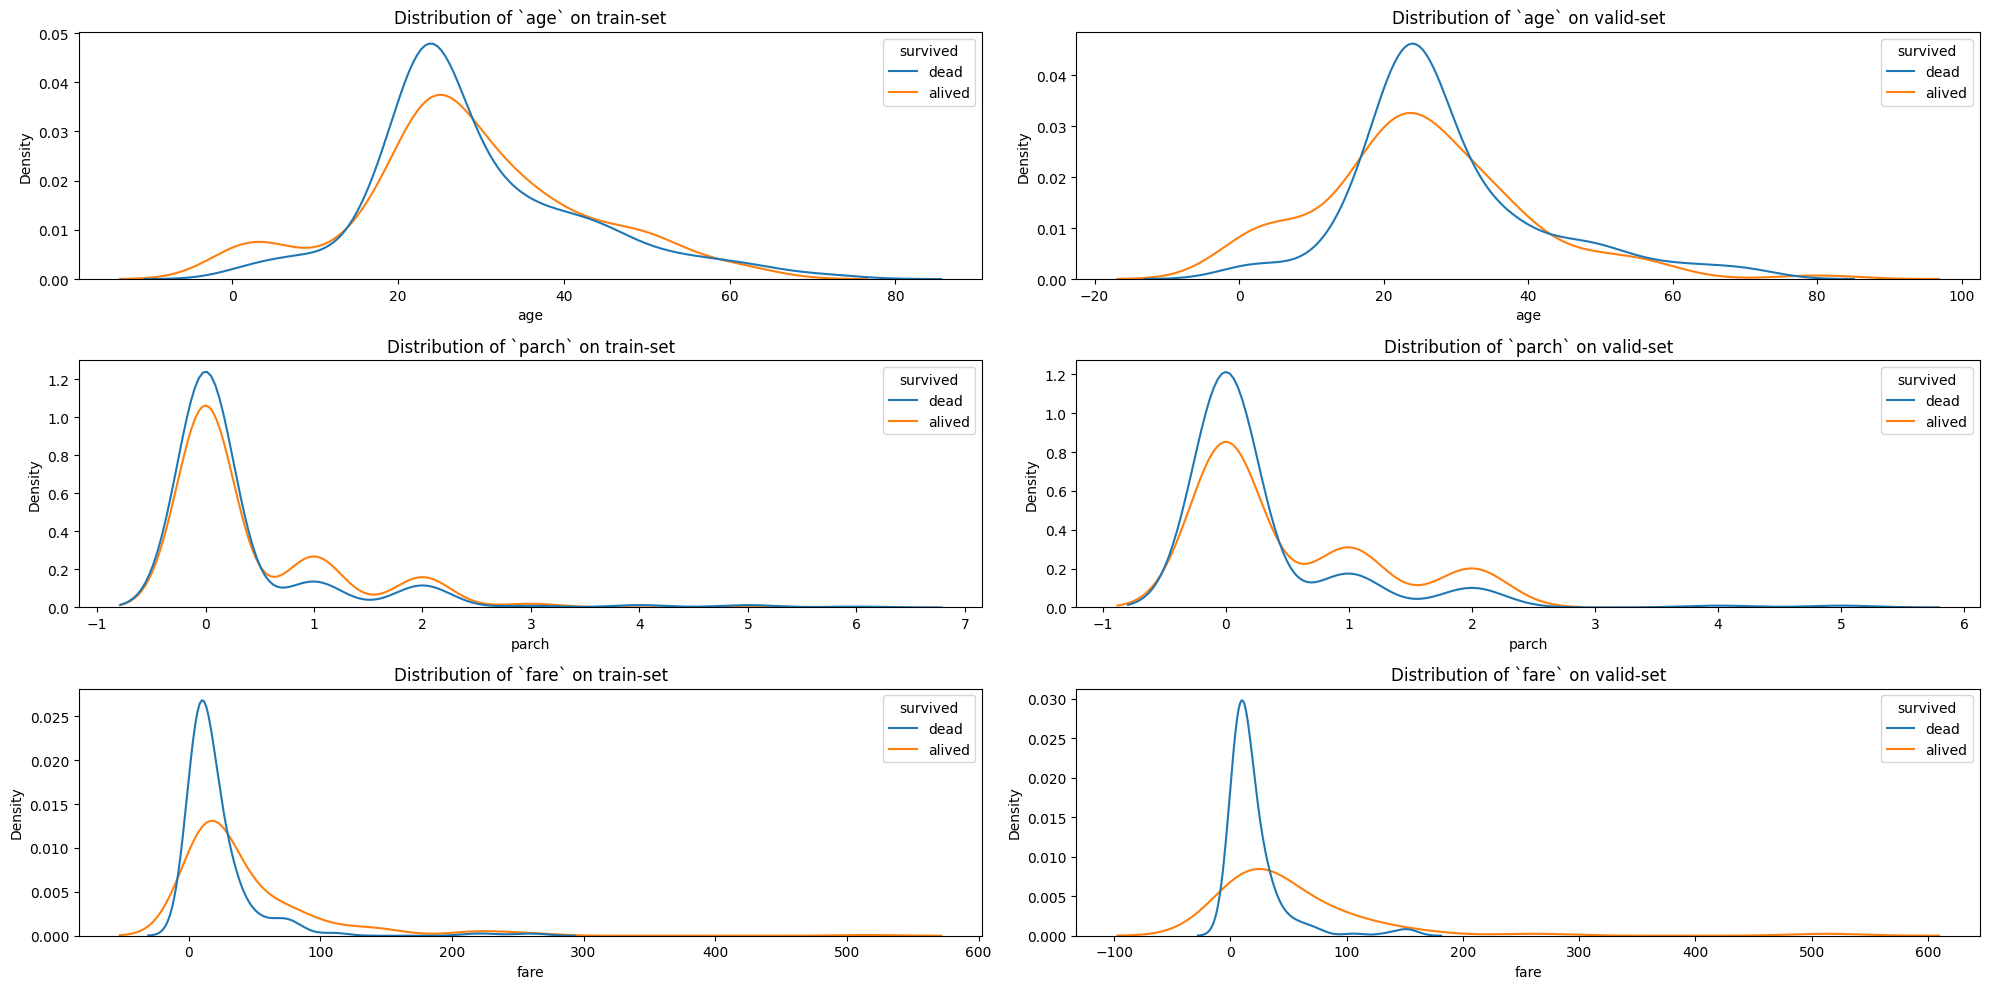

In [7]:
numeric_vrs = ['age', 'parch', 'fare']
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes = axes.ravel()
for idx, col in enumerate(numeric_vrs):
    sns.kdeplot(df_train, x=col, hue='survived', hue_order=['dead','alived'], common_norm=False, ax=axes[2*idx])
    sns.kdeplot(df_valid, x=col, hue='survived', hue_order=['dead','alived'], common_norm=False, ax=axes[2*idx+1])
    axes[2*idx].set_title(f"Distribution of `{col}` on train-set")
    axes[2*idx+1].set_title(f"Distribution of `{col}` on valid-set")    
plt.tight_layout()

#### 1.5.3. Scatterplot
x = `age`, y = `fare` and color = `surrvived`

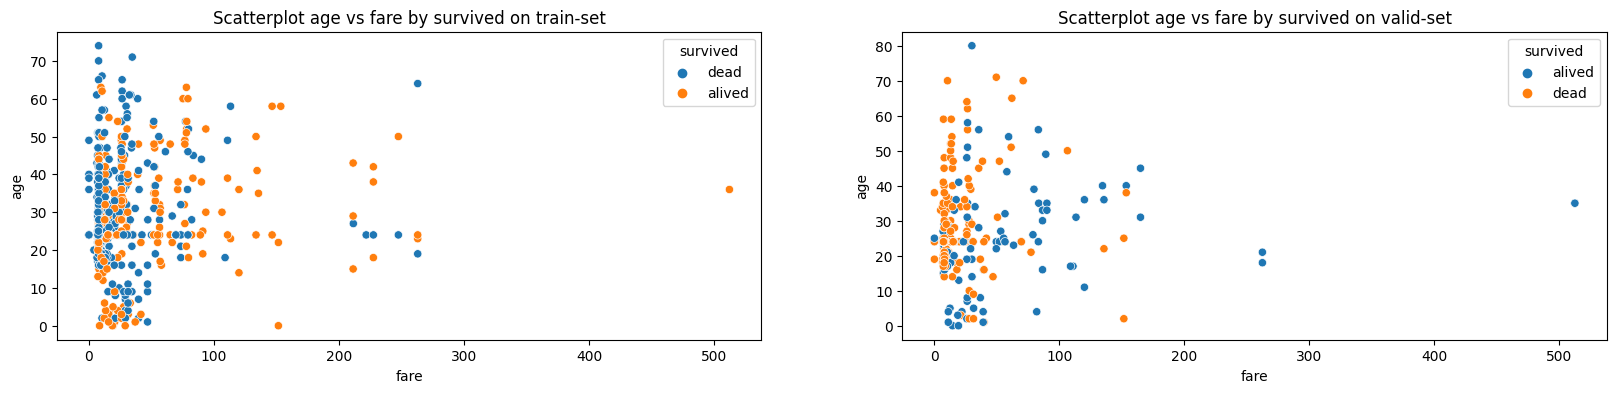

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
sns.scatterplot(df_train, y = 'age', x = 'fare', hue = 'survived', ax = ax[0])
sns.scatterplot(df_valid, y = 'age', x = 'fare', hue = 'survived', ax = ax[1])
ax[0].set_title("Scatterplot age vs fare by survived on train-set")
ax[1].set_title("Scatterplot age vs fare by survived on valid-set");

## 2. Comparison
### 2.1 Traditional ML
#### 2.1.1. Create dummy data on the categorical-variables

In [9]:
dummy_train_df = pd.get_dummies(df_train[categorial_vrs], prefix_sep='_is_')
dummy_valid_df = pd.get_dummies(df_valid[categorial_vrs], prefix_sep='_is_')
dummy_train_df.head()

,sex_is_female,sex_is_male,class_is_First,class_is_Second,class_is_Third,alone_is_False,alone_is_True,embark_town_is_Cherbourg,embark_town_is_Queenstown,embark_town_is_Southampton
0,False,True,False,False,True,False,True,False,False,True
1,True,False,False,False,True,True,False,False,False,True
2,False,True,False,False,True,False,True,False,False,True
3,False,True,False,False,True,False,True,False,False,True
4,True,False,False,True,False,False,True,False,False,True


#### 2.1.2. Concatenate categorial_data vs numerical_data

In [10]:
ml_trad_train_df = pd.concat([dummy_train_df, df_train[['age', 'parch', 'fare', 'survived']] ], axis=1)
ml_trad_valid_df = pd.concat([dummy_valid_df, df_valid[['age', 'parch', 'fare', 'survived']] ], axis=1)
ml_trad_train_df.head()

,sex_is_female,sex_is_male,class_is_First,class_is_Second,class_is_Third,alone_is_False,alone_is_True,embark_town_is_Cherbourg,embark_town_is_Queenstown,embark_town_is_Southampton,age,parch,fare,survived
0,False,True,False,False,True,False,True,False,False,True,20,0,7.8542,dead
1,True,False,False,False,True,True,False,False,False,True,24,1,25.4667,dead
2,False,True,False,False,True,False,True,False,False,True,21,0,7.8542,dead
3,False,True,False,False,True,False,True,False,False,True,24,0,7.3125,dead
4,True,False,False,True,False,False,True,False,False,True,36,0,13.0000,alived


#### 2.1.3. Model evaluation 

In [11]:
# check lightgbm version
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

X_train, y_train = ml_trad_train_df.drop(columns='survived'), ml_trad_train_df['survived']
X_valid, y_valid = ml_trad_valid_df.drop(columns='survived'), ml_trad_valid_df['survived']
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

#### 2.1.4. Metric-evaluation: confusion matrix vs f1-score

Classification report on the valid-set, 

              precision    recall  f1-score   support

      alived       0.75      0.66      0.70       115
        dead       0.76      0.83      0.79       152

    accuracy                           0.76       267
   macro avg       0.75      0.74      0.75       267
weighted avg       0.76      0.76      0.75       267



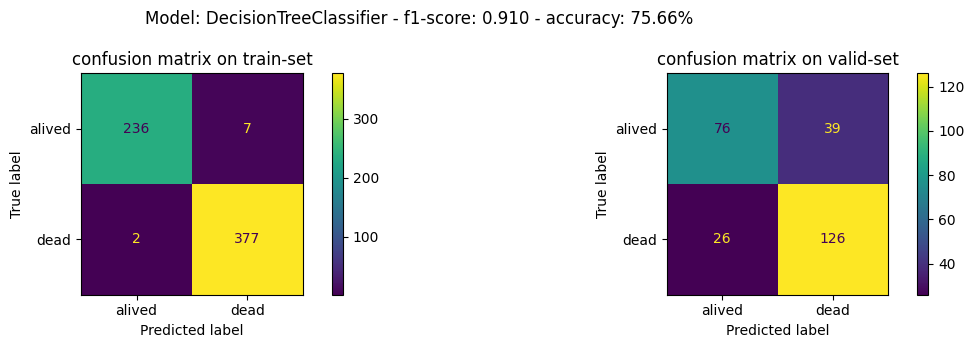

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score

def summarize(model, X_train, y_train, X_valid, y_valid, display_report=True):
    y_pred = model.predict(X_valid)
    binarizer = MultiLabelBinarizer()
    binarizer.fit(y_valid)
    cm_train = confusion_matrix(model.predict(X_train), y_train)
    cm_valid = confusion_matrix(y_pred, y_valid)
    disp1 = ConfusionMatrixDisplay(cm_valid, display_labels=model.classes_)
    disp2 = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))
    disp1.plot(ax = ax[1])
    disp2.plot(ax = ax[0])
    f1 = f1_score(binarizer.transform(y_pred), binarizer.transform(y_valid), average='weighted')
    acc = 100*accuracy_score(binarizer.transform(y_pred), binarizer.transform(y_valid))
    plt.suptitle(f"Model: {model.__class__.__name__} - f1-score: {f1:.3f} - accuracy: {acc:.2f}%")
    ax[0].set_title("confusion matrix on train-set")
    ax[1].set_title("confusion matrix on valid-set")
    plt.tight_layout()
    if display_report:
        print("Classification report on the valid-set, \n")
        print(classification_report(y_pred, y_valid))
    
summarize(dt_clf, X_train, y_train, X_valid, y_valid)

#### 2.1.5. Model comparison

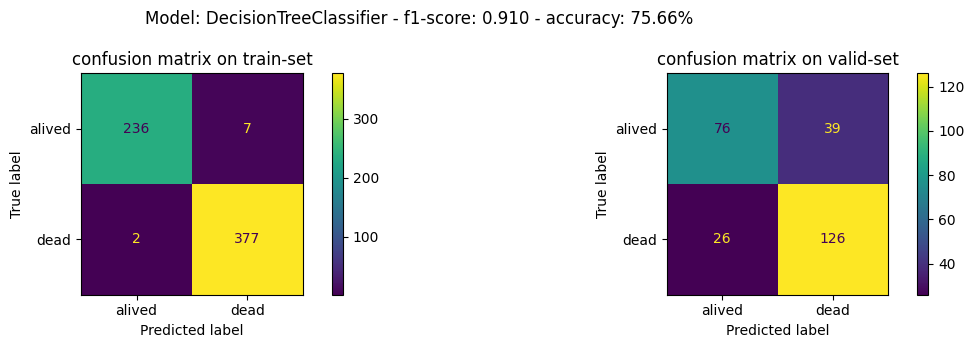

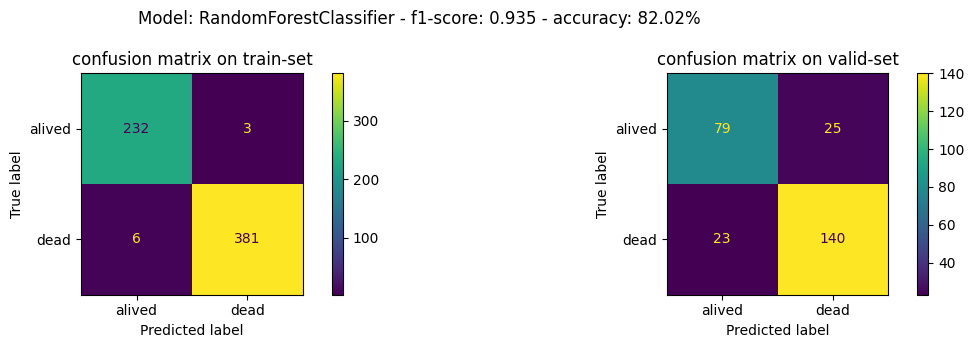

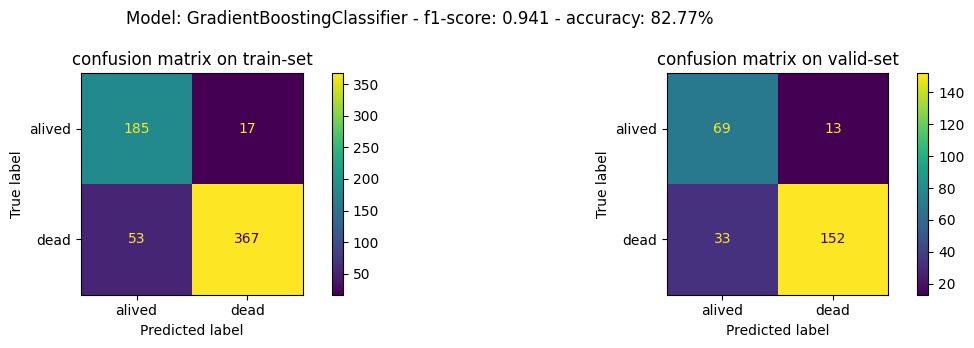

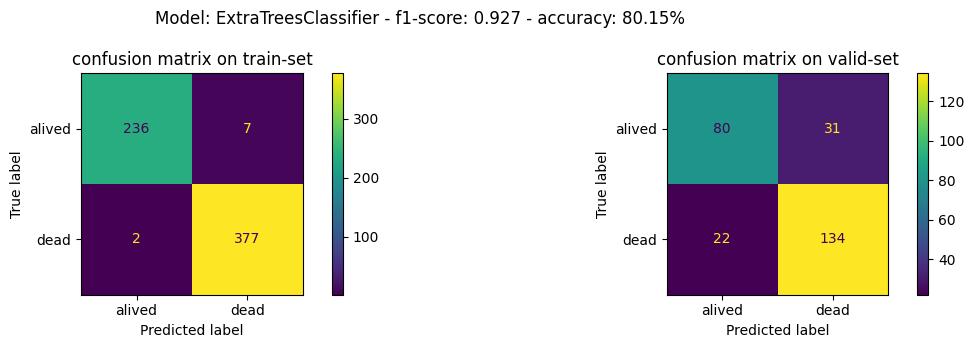

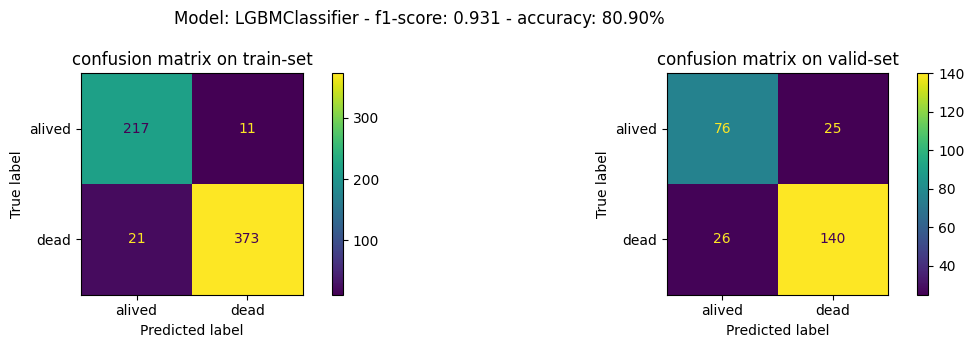

In [13]:
for model in [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), ExtraTreesClassifier(), LGBMClassifier(verbose=-1)]:
    model.fit(X_train, y_train)
    summarize(model, X_train, y_train, X_valid, y_valid, display_report=False)

### 2.2. AutoML
#### 2.2.1. Intialize h2o

In [14]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8jrbj2q7
  JVM stdout: /tmp/tmp8jrbj2q7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8jrbj2q7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_f5eu8e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.231 Gb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


#### 2.2.2. Transform your input to h2o-frame

In [15]:
h2o_train_df = h2o.H2OFrame(df_train)
h2o_valid_df = h2o.H2OFrame(df_valid)
h2o_train_df.head(5)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


age,parch,fare,class,alone,sex,embark_town,survived
20,0,7.8542,Third,True,male,Southampton,dead
24,1,25.4667,Third,False,female,Southampton,dead
21,0,7.8542,Third,True,male,Southampton,dead
24,0,7.3125,Third,True,male,Southampton,dead
36,0,13,Second,True,female,Southampton,alived


#### 2.2.3. Run AutoML for training

In [16]:
from h2o.automl import H2OAutoML
# callh20automl  function 
aml = H2OAutoML(max_runtime_secs = 300,
                # exclude_algos =['DeepLearning'],
                stopping_metric ='logloss',
                sort_metric ='accuracy',
                balance_classes = False
)
# train model and record time % time 
aml.train(x = df_train.drop(columns='survived').columns.tolist(), 
          y = 'survived', training_frame = h2o_train_df)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20240303_110302_model_15


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    22                 22                          49771                  10           10           10            86            228           175.409

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.030048744012773222
RMSE: 0.17334573549058893
LogLoss: 0.1506574179953582
Mean Per-Class Error: 0.016215861344537813
AUC: 0.997735031512605
AUCPR: 0.9986572712507049
Gini: 0.99547006302521

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6140488114142597
        alived    dead    Error    Rate
------  --------  ------  -------  ------------
alived  234       4       0.0168   (4.0/238.0)
dead    6         378     0.0156   (6.0/384.0)
Total   240       382     0.0161   (10.0/622.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.614049     0.986945  242
max f2                       0.500706     0.989664  254
max f0point5                 0.678405     0.988924  240
max accuracy                 0.614049     0.983923  242
max precision                0.960567     1         0
max recall                   0.155588     1         313
max specificity              0.960567     1         0
max absolute_mcc             0.614049     0.966047  242
max min_per_class_accuracy   0.614049     0.983193  242
max mean_per_class_accuracy  0.614049     0.983784  242
max tns                      0.960567     238       0
max fns                      0.960567     383       0
max fps                      0.0562432    238       399
max tps                      0.155588     384       313
max tnr                      0.960567     1         0
max fnr                      0.960567     0.997396  0
max fpr                      0.0562432    1         399
max tpr                      0.155588     1         313

Gains/Lift Table: Avg response rate: 61.74 %, avg score: 61.90 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011254                    0.958481           1.61979    1.61979            1                0.95945    1                           0.95945             0.0182292       0.0182292                  61.9792   61.9792            0.0182292
2        0.0209003                   0.957593           1.61979    1.61979            1                0.957705   1                           0.958645            0.015625        0.0338542                  61.9792   61.9792            0.0338542
3        0.0305466                   0.955007           1.61979    1.61979            1                0.956626   1                           0.958007            0.015625        0.0494792                  61.9792   61.9792            0.0494792
4        0.0401929                   0.954081           1.61979    1.61979            1                0.95454    1                           0.957175            0.015625        0.0651042                  61.9792   61.9792            0.0651042
5        0.0514469                   0.953225           1.61979    1.61979            1             

#### 2.2.4. Top best performing models

In [17]:
##View the H2O aml leaderboard
lb = aml.leaderboard
# Print top 10 rows instead of all rows (lb.nrows)
lb.head(rows = 10)

model_id,accuracy,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20240303_110302_model_15,0.790997,0.829881,0.498209,0.859762,0.252046,0.398971,0.159178
GBM_grid_1_AutoML_1_20240303_110302_model_14,0.792605,0.842596,0.482934,0.877386,0.237461,0.394184,0.155381
DeepLearning_grid_1_AutoML_1_20240303_110302_model_4,0.794212,0.820181,0.497756,0.830926,0.257725,0.394311,0.155481
XGBoost_lr_search_selection_AutoML_1_20240303_110302_select_grid_model_1,0.79582,0.820422,0.486744,0.821409,0.27962,0.394356,0.155517
GBM_grid_1_AutoML_1_20240303_110302_model_3,0.79582,0.829668,0.4863,0.858584,0.25802,0.395468,0.156395
DeepLearning_grid_3_AutoML_1_20240303_110302_model_3,0.797428,0.822452,0.483596,0.841118,0.268021,0.388828,0.151187
DeepLearning_grid_2_AutoML_1_20240303_110302_model_2,0.797428,0.827901,0.64087,0.853756,0.254322,0.413762,0.171199
DeepLearning_grid_3_AutoML_1_20240303_110302_model_2,0.797428,0.838301,0.494363,0.85822,0.255624,0.399345,0.159476
StackedEnsemble_AllModels_5_AutoML_1_20240303_110302,0.799035,0.852126,0.460206,0.873747,0.237045,0.384244,0.147643
GBM_grid_1_AutoML_1_20240303_110302_model_2,0.799035,0.838268,0.471664,0.861554,0.248435,0.388247,0.150736


In [18]:
list_model = np.array(h2o.as_list(lb['model_id'])).tolist()
list_model = [model_name[0] for model_name in list_model]
list_model[0]

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


'GBM_grid_1_AutoML_1_20240303_110302_model_15'

### 2.2.5. All metrics evaluation from the top-best

In [19]:
# model performance on test dataset
model = h2o.get_model(list_model[0])
model.model_performance(h2o_valid_df)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12919855925235452
RMSE: 0.359442010973056
LogLoss: 0.42399647565016835
Mean Per-Class Error: 0.1852941176470588
AUC: 0.8601307189542484
AUCPR: 0.8576822995086715
Gini: 0.7202614379084968

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3452652792882854
        alived    dead    Error    Rate
------  --------  ------  -------  ------------
alived  71        31      0.3039   (31.0/102.0)
dead    11        154     0.0667   (11.0/165.0)
Total   82        185     0.1573   (42.0/267.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345265     0.88      158
max f2                       0.112678     0.926773  186
max f0point5                 0.709878     0.869281  125
max accuracy                 0.39528      0.842697  152
max precision                0.950554     0.933333  14
max recall                   0.0650215    1         225
max specificity              0.963512     0.990196  0
max absolute_mcc             0.345265     0.662955  158
max min_per_class_accuracy   0.685893     0.813725  128
max mean_per_class_accuracy  0.487498     0.821034  148
max tns                      0.963512     101       0
max fns                      0.963512     165       0
max fps                      0.0619736    102       237
max tps                      0.0650215    165       225
max tnr                      0.963512     0.990196  0
max fnr                      0.963512     1         0
max fpr                      0.0619736    1         237
max tpr                      0.0650215    1         225

Gains/Lift Table: Avg response rate: 61.80 %, avg score: 60.89 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011236                    0.955987           1.07879    1.07879            0.666667         0.960384  0.666667                    0.960384            0.0121212       0.0121212                  7.87879   7.87879            0.00231729
2        0.0224719                   0.954936           1.61818    1.34848            1                0.955033  0.833333                    0.957709            0.0181818       0.030303                   61.8182   34.8485            0.0204991
3        0.0299625                   0.954839           1.61818    1.41591            1                0.954919  0.875                       0.957011            0.0121212       0.0424242                  61.8182   41.5909            0.0326203
4        0.0411985                   0.951399           1.61818    1.47107            1                0.953466  0.909091                    0.956044            0.0181818       0.0606061                  61.8182   47.1074            0.0508021
5        0.0524345                   0.950837           1.61818    1.5026             1                0.951045  0.928571                    0.954973            0.0181818       0.0787879                  61.8182   50.2597            0.068984
6        0.101124                    0.940589           1.24476    1.37845            0.769231         0.945647  0.851852                    0.950483            0.0606061       0.139394                   24.4755   37.8451            0.100178
7        0.153558                    0.936668           1.38701    1.38137            0.857143         0.937714  0.853659                    0.946123            0.0727273       0.212121                   38.7013   38.1375            0.15329

And also the `variable importance`

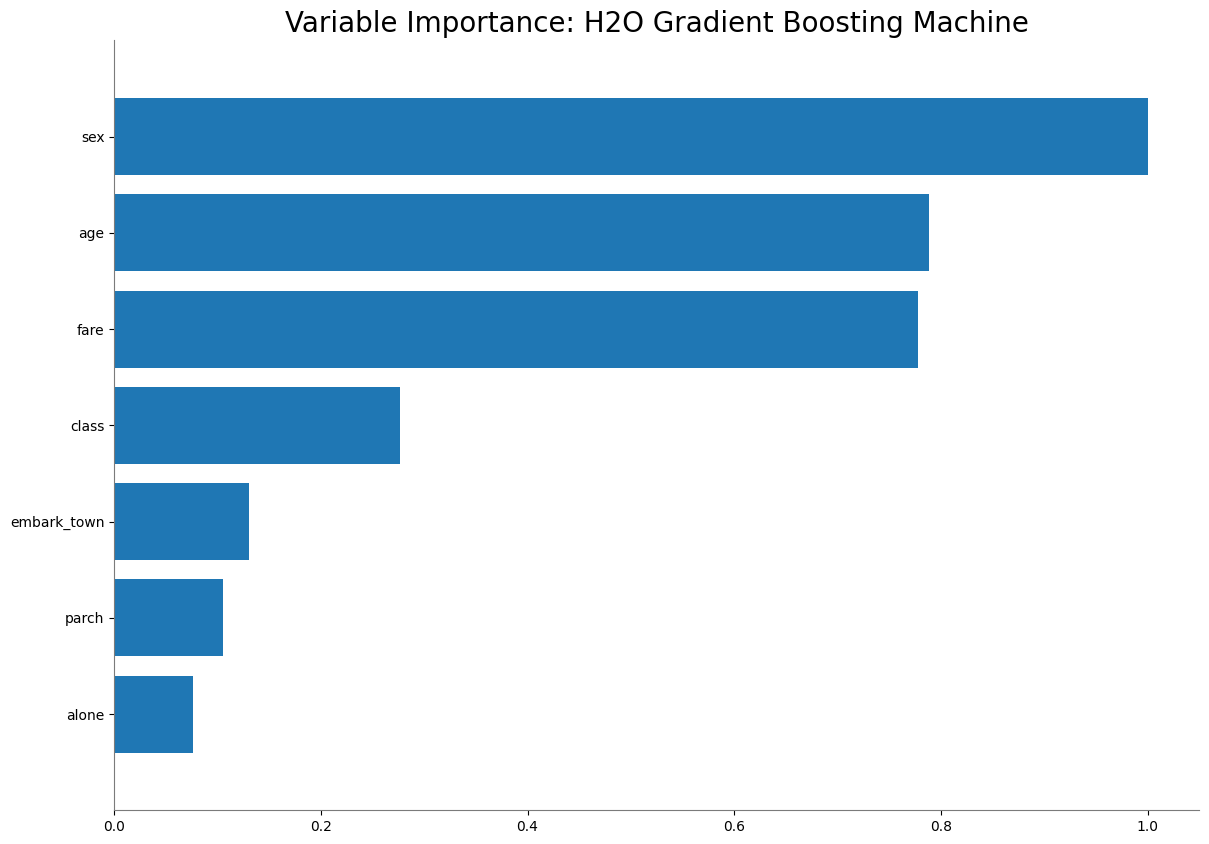

In [20]:
res = model.varimp_plot(num_of_features = 10, server=True)
res.figure()

#### Save model

In [21]:
model_path = h2o.save_model(model = model, path ='sample_data/', force = True)

#### 2.2.6. Predict

In [22]:
new_response_df = pd.DataFrame({'age': [50, 26],
                                'parch': [0, 0],
                                'fare': [8, 18],
                                'class': ['Second', 'First'],
                                'alone': [True, False],
                                'sex': ['male', 'male'],
                                'embark_town': ['Southampton', 'Cherbourg']
                               })
new_response_df = h2o.H2OFrame(new_response_df)
new_response_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


age,parch,fare,class,alone,sex,embark_town
50,0,8,Second,True,male,Southampton
26,0,18,First,False,male,Cherbourg


In [23]:
model.predict(new_response_df)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,alived,dead
dead,0.155309,0.844691
dead,0.271992,0.728008
